## Prelude

In [1]:
%pip install datasets
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import os
import json

from math import exp

In [3]:
SEED = 42

In [4]:
from calibration_dataset import CalibrationDataset
from calibration_run import CalibrationRun
import gsm8k_helpers
import math_helpers
from cost_acc_gen import cost_acc_curve_points

  Cloning https://github.com/hendrycks/math.git to /tmp/pip-req-build-74fmx1io


  Running command git clone --filter=blob:none --quiet https://github.com/hendrycks/math.git /tmp/pip-req-build-74fmx1io


  Resolved https://github.com/hendrycks/math.git to commit 357963a7f5501a6c1708cf3f3fb0cdf525642761
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [5]:
gsm8k_df = gsm8k_helpers.get_test_df()

In [49]:
math_df = pd.read_parquet('./data/math_test.pq')

## GSM8K

In [230]:
gsm8k_all = CalibrationDataset(
    dataset_name="gsm8k_all",
    df = gsm8k_df,
    is_equiv = gsm8k_helpers.is_equiv,
    get_value_from_response=gsm8k_helpers.str_to_num_parser,
    get_prompt_content=gsm8k_helpers.get_prompt_content,
    get_value_tokens_prob=gsm8k_helpers.get_tokens_prob,
    seed=SEED,
)

### All 8B

In [231]:
gsm8k_all_llama3_8b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_8b.jsonl",
    results_file_pattern="results/gsm8k_all_llama3_8b.jsonl*",
)
# gsm8k_all_llama3_8b.write_requests_file()
gsm8k_all_llama3_8b.read_results_file()

100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


Lines dropped: 0


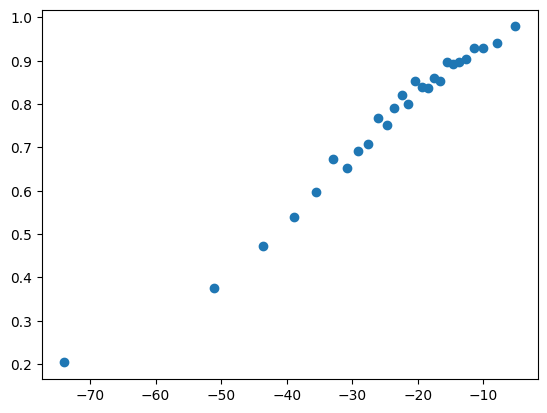

In [232]:
binned = gsm8k_all_llama3_8b.get_binned(confidence_estimator="all_tokens_logprob", qa_pairs_per_bin=1000)
plt.scatter(binned["all_tokens_logprob"], binned['correct'])

Binned r2 (qa_pairs_per_bin=100): 0.8647372357667356


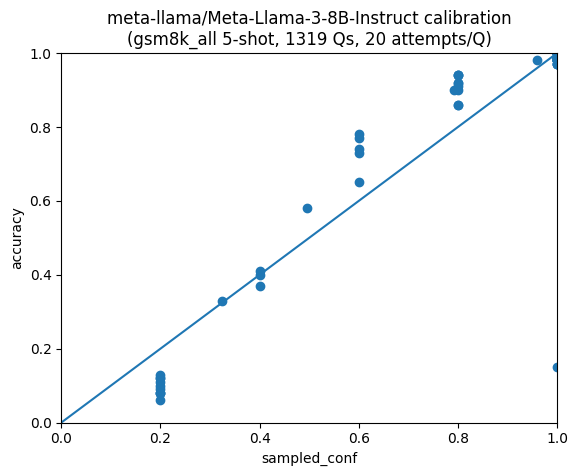

Binned r2 (qa_pairs_per_bin=100): 0.9062680511059267


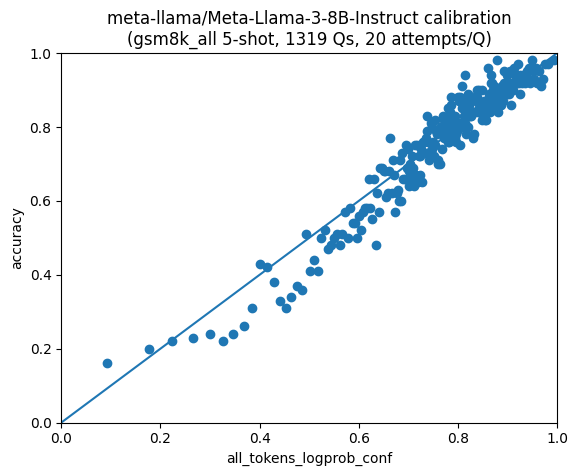

In [233]:
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="sampled_conf", qa_pairs_per_bin=100)
gsm8k_all_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=100)

### All 70B

In [257]:
gsm8k_all_llama3_70b = CalibrationRun(
    dataset=gsm8k_all,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1319,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=1000,
    requests_file_path="requests/gsm8k_all_llama3_70b.jsonl",
    results_file_pattern="results/gsm8k_all_llama3_70b.jsonl*",
)
# gsm8k_all_llama3_70b.write_requests_file()
gsm8k_all_llama3_70b.read_results_file()

100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Lines dropped: 0


Binned r2 (qa_pairs_per_bin=100): 0.968420386596661


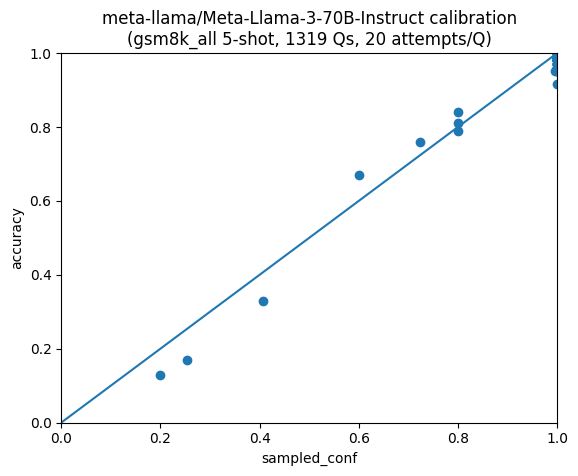

Binned r2 (qa_pairs_per_bin=1000): 0.9164417643543545


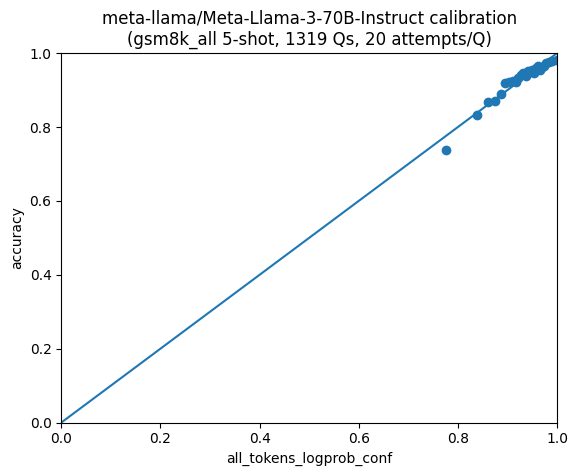

In [258]:
gsm8k_all_llama3_70b.plot_estimated_confidence_vs_accuracy(confidence_estimator="sampled_conf", qa_pairs_per_bin=100)
gsm8k_all_llama3_70b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=1000)

### Cost-Accuracy Tradeoff

#### Sampled Confidence

Text(0, 0.5, 'Accuracy')

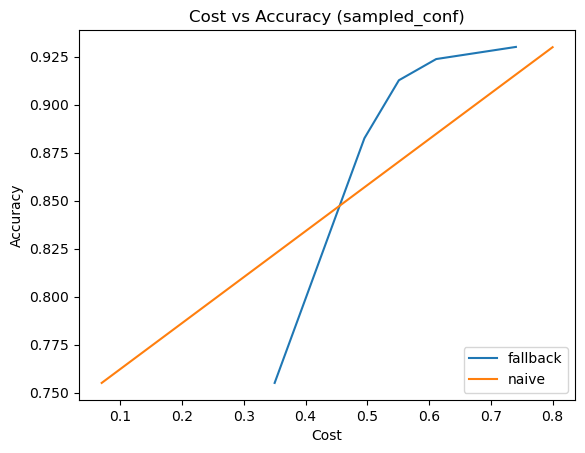

In [12]:
cost_acc_df = cost_acc_curve_points(
    confidence_estimator="sampled_conf",
    run_small=gsm8k_all_llama3_8b,
    run_big=gsm8k_all_llama3_70b,
    cost_small=0.07,
    cost_big=0.8
)

cost_acc_df = pd.concat([pd.DataFrame([[0, 0.35, 0.755]], columns=cost_acc_df.columns), cost_acc_df], ignore_index=True) # hack to fill NAs at low confidence thresholds
cost_acc_df = cost_acc_df.dropna()

fig, ax = plt.subplots()
plt.plot(cost_acc_df['cost'], cost_acc_df['acc'], label='fallback')
ax.plot([0.07,0.8],[0.755,0.93], label='naive') # hacky way to draw line
plt.legend(loc='lower right')
plt.title("Cost vs Accuracy (sampled_conf)")
plt.xlabel("Cost")
plt.ylabel("Accuracy")

#### All Tokens Logprob Confidence

Text(0, 0.5, 'Accuracy')

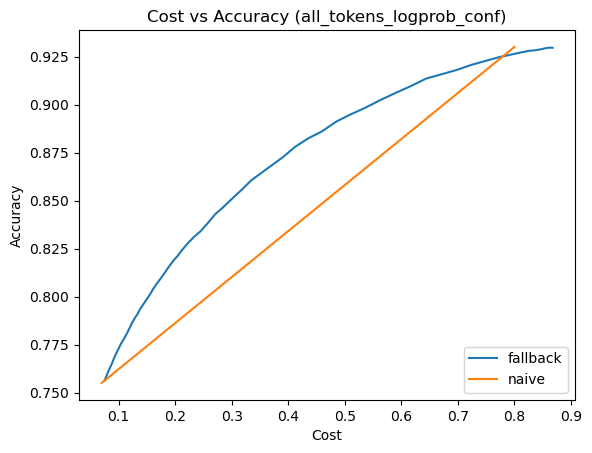

In [13]:
cost_acc_df = cost_acc_curve_points(
    confidence_estimator="all_tokens_logprob_conf",
    run_small=gsm8k_all_llama3_8b,
    run_big=gsm8k_all_llama3_70b,
    cost_small=0.07,
    cost_big=0.8
)

fig, ax = plt.subplots()
plt.plot(cost_acc_df['cost'], cost_acc_df['acc'], label='fallback')
ax.plot([0.07,0.8],[0.755,0.93], label='naive')
plt.legend(loc='lower right')
plt.title("Cost vs Accuracy (all_tokens_logprob_conf)")
plt.xlabel("Cost")
plt.ylabel("Accuracy")

## MATH

### 1000Q

In [52]:
math_1000 = CalibrationDataset(
    dataset_name="math_1000",
    df = math_df.sample(1000, random_state=SEED),
    is_equiv = math_helpers.is_equiv,
    get_value_from_response=math_helpers.extract_boxed_expression,
    get_prompt_content=math_helpers.get_prompt_content,
    get_value_tokens_prob=lambda x: None,
    seed=SEED,
)

#### 1000Q 8B

In [53]:
math_1000_llama3_8b = CalibrationRun(
    dataset=math_1000,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=1000,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/math_1000q_llama3_8b.jsonl",
    results_file_pattern="results/math_1000q_llama3_8b.jsonl*",
)
# math_1000_llama3_8b.write_requests_file()
math_1000_llama3_8b.read_results_file()

100%|██████████| 4/4 [00:07<00:00,  1.96s/it]


Lines dropped: 0


Binned r2 (qa_pairs_per_bin=100): 0.6860649079571718


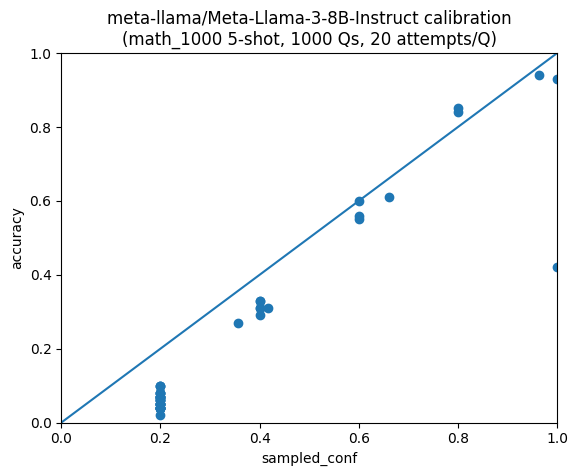

Binned r2 (qa_pairs_per_bin=50): 0.5145134849688331


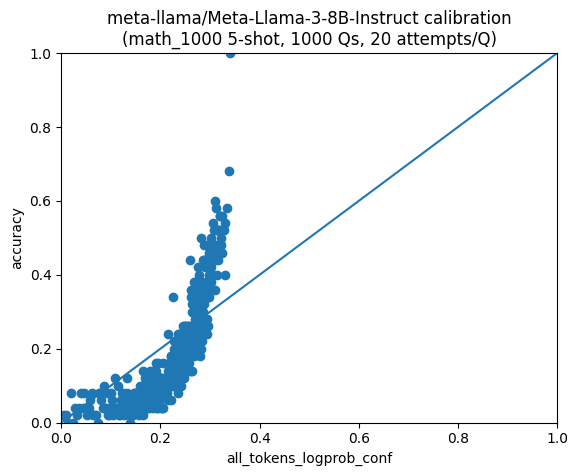

In [54]:
math_1000_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="sampled_conf", qa_pairs_per_bin=100)
math_1000_llama3_8b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=50)

#### 1000Q 70B

In [55]:
math_1000_llama3_70b = CalibrationRun(
    dataset=math_1000,
    model_name="meta-llama/Meta-Llama-3-70B-Instruct",
    num_questions=1000,
    num_attempts_per_question=20,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/math_1000q_llama3_70b.jsonl",
    results_file_pattern="results/math_1000q_llama3_70b.jsonl*",
)
# math_1000_llama3_8b.write_requests_file()
math_1000_llama3_70b.read_results_file()

100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


Lines dropped: 0


Binned r2 (qa_pairs_per_bin=100): 0.9341484293022859


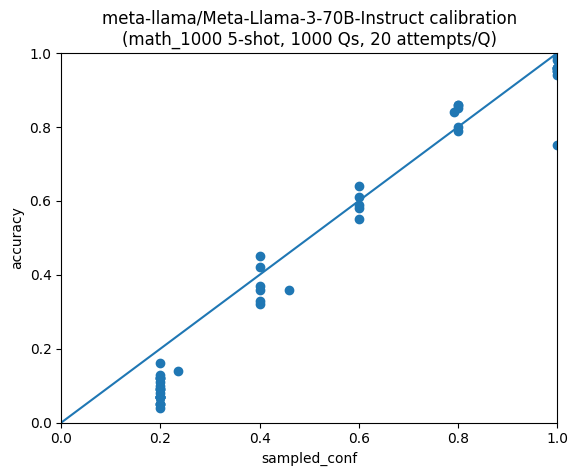

Binned r2 (qa_pairs_per_bin=50): 0.6547342448185918


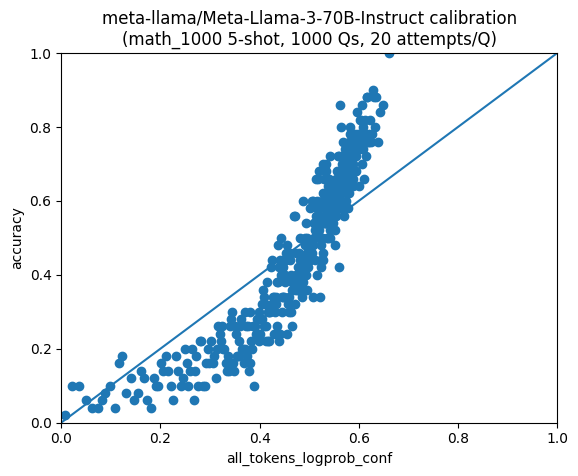

In [56]:
math_1000_llama3_70b.plot_estimated_confidence_vs_accuracy(confidence_estimator="sampled_conf", qa_pairs_per_bin=100)
math_1000_llama3_70b.plot_estimated_confidence_vs_accuracy(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=50)

### MATH all

In [57]:
math_all = CalibrationDataset(
    dataset_name="math_all",
    df = math_df.copy(),
    is_equiv = math_helpers.is_equiv,
    get_value_from_response=math_helpers.extract_boxed_expression,
    get_prompt_content=math_helpers.get_prompt_content,
    get_value_tokens_prob=lambda x: None,
    seed=SEED,
)

#### all 8B

In [9]:
math_all_llama3_8b = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=5000,
    num_attempts_per_question=4,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path="requests/math_all_4a_250c_llama3_8b.jsonl",
    results_file_pattern="results/math_all_4a_250c_llama3_8b.jsonl*",
    num_choices=250,
)
math_all_llama3_8b.write_requests_file()
# math_all_llama3_8b.read_results_file()

## TriviaQA

## Scratch

In [58]:
test = CalibrationRun(
    dataset=math_all,
    model_name="meta-llama/Meta-Llama-3-8B-Instruct",
    num_questions=5000,
    num_attempts_per_question=4,
    num_shots=5,
    max_response_tokens=5000,
    requests_file_path=None,
    results_file_pattern="../math_8b_requests_*.jsonl.results",
    num_choices=250,
)
# math_all_llama3_8b.write_requests_file()
test.read_results_file()

100%|██████████| 38/38 [11:56<00:00, 18.86s/it]


Lines dropped: 0


In [ ]:
# beta = (math_1000_llama3_8b.results['completion_tokens'] * math_1000_llama3_8b.results['all_tokens_logprob']).sum() / (math_1000_llama3_8b.results['completion_tokens'] ** 2).sum() 
# math_1000_llama3_8b.results['all_tokens_logprob'] = math_1000_llama3_8b.results['all_tokens_logprob'] - beta * math_1000_llama3_8b.results['completion_tokens']

In [60]:
test.get_binned(confidence_estimator="all_tokens_logprob_conf", qa_pairs_per_bin=100)

,all_tokens_logprob_conf,correct
bin,,
0,-1.168609,0.02
1,-0.295437,0.00
2,-0.235159,0.00
3,-0.202206,0.01
4,-0.181714,0.01
...,...,...
1515,0.307647,1.00
1516,0.307825,1.00
1517,0.308113,1.00


In [168]:
test.results.query("q_id == 1485").question.head(10).iloc[1]

'Let $f(x) = 12x+7$ and $g(x) = 5x+2$ whenever $x$ is a positive integer. Define $h(x)$ to be the greatest common divisor of $f(x)$ and $g(x)$. What is the sum of all possible values of $h(x)$?'

In [169]:
test.results.query("q_id == 1485").answer.head(10).iloc[1]

'Use the Euclidean algorithm on $f(x)$ and $g(x)$. \\begin{align*}\nh(x) &= \\gcd(f(x), g(x)) \\\\\n&= \\gcd(12x+7, 5x+2) \\\\\n&= \\gcd(5x+2, (12x+7)-2(5x+2)) \\\\\n&= \\gcd(5x+2, 2x + 3) \\\\\n&= \\gcd(2x+3, (5x+2)-2(2x+3)) \\\\\n&= \\gcd(2x+3, x - 4) \\\\\n&= \\gcd(x-4, (2x+3)-2(x-4)) \\\\\n&= \\gcd(x-4, 11)\n\\end{align*}From applying the Euclidean algorithm, we have that the greatest common divisor of $f(x)$ and $g(x)$ is 11 if and only if $x-4$ is a multiple of 11. For example, note that $f(4) = 55$ and $g(4) = 22$, and the greatest common divisor of 55 and 22 turns out to be 11. If $x-4$ is not a multiple of 11, then the greatest common divisor of $f(x)$ and $g(x)$ must be one, since 11 is prime and therefore has no other factors. It follows that $h(x)$ can take on two distinct values; 1 and 11. The sum of all possible values of $h(x)$ is therefore $1 + 11 = \\boxed{12}$.'

In [174]:
test.results.query("q_id == 1485").head(10).iloc[3].all_tokens_logprob

-16.76436342827153

In [211]:
confs[confs.correct == 1].sort_values("sampled_conf", ascending=False).groupby("q_id").first().reset_index().sort_values("sampled_conf", ascending=False).head(10)

,q_id,attempt_value,correct,sampled_conf
232,2575,10,1,0.996
69,705,\frac{1}{4},1,0.992
141,1501,12,1,0.988
234,2586,55,1,0.984
99,1055,\frac{3}{2},1,0.984
431,4328,200,1,0.924
321,3316,64,1,0.912
223,2480,70,1,0.904
501,4995,-7,1,0.904
317,3268,\frac{11}{15},1,0.896


In [216]:
(
    test.results[['q_id', 'attempt_value', 'all_tokens_logprob', 'correct']]
    .assign(ones=1)
    .query("q_id == 4995")
    .groupby("attempt_value")
    .agg({"all_tokens_logprob": "mean", "correct": "mean", "ones": "sum"})
    .reset_index()
    .sort_values("ones", ascending=False)
)

,attempt_value,all_tokens_logprob,correct,ones
2,-7,-22.316239,1.0,226
1,-5,-28.902845,0.0,5
0,-2,-10.780946,0.0,4
3,-8,-30.991363,0.0,3
7,p(q(2)) = -7,-28.242607,0.0,3
5,3,-29.741309,0.0,2
4,0,-33.471429,0.0,1
6,p(q(2)) = -5,-26.576469,0.0,1
8,p(q(2)) = -8,-25.939561,0.0,1
9,p(q(2)) = p(3) = -7,-28.617987,0.0,1


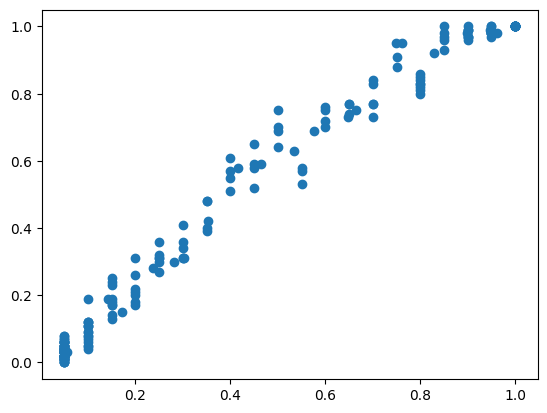

In [326]:
confs = math_1000_llama3_70b.results[['q_id', 'attempt_value', 'correct']].merge(
    math_1000_llama3_70b.results[['q_id', 'attempt_value']]
    .assign(sampled_conf=1/20)
    .groupby(['q_id', 'attempt_value'])
    .sum()
    .reset_index(),
    on=['q_id', 'attempt_value'],
    how='left',
)

binned = (
    confs.dropna()
    .sort_values("sampled_conf")
    .reset_index(drop=True)
    .assign(bin=lambda row: row.index // 100)[['bin', "sampled_conf", 'correct']]
    .groupby('bin')
    .mean()
)
plt.scatter(binned["sampled_conf"], binned['correct'])

correct
1.0    264
0.0     12
Name: count, dtype: int64
0.9565217391304348


,q_id,attempt_value,correct,sampled_conf
538,2689,1,0.0,0.95
936,4719,\sqrt{\pi},0.0,0.90
592,2957,1:03,0.0,0.85
320,1499,M,0.0,0.80
456,2275,1,0.0,0.80
...,...,...,...,...
174,776,\frac{441}{24},0.0,0.05
426,2117,"\left\langle -\frac{5}{3}, \frac{2}{3}, \frac{...",0.0,0.05
19,84,\frac{2574336}{2598960}=\frac{42973}{53979},0.0,0.05
473,2330,-1,0.0,0.05


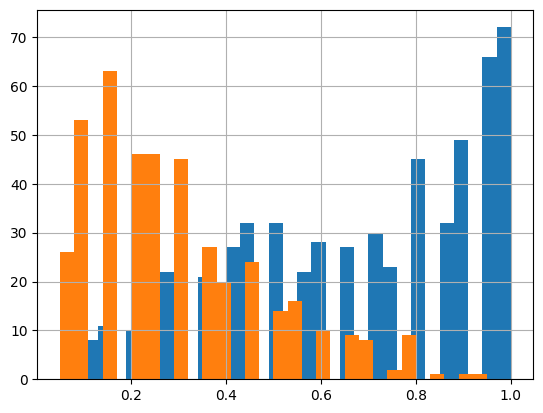

In [338]:
top_choices = confs.groupby(["q_id", "attempt_value"]).mean().reset_index().sort_values("sampled_conf", ascending=False).groupby("q_id").first().reset_index()
print(top_choices.query("sampled_conf >= 0.79").correct.value_counts())
print(top_choices.query("sampled_conf >= 0.79").correct.mean())
top_choices[top_choices.correct == 1].sampled_conf.hist(bins=30)
top_choices[top_choices.correct == 0].sampled_conf.hist(bins=30)
top_choices.query("correct == 0").sort_values("sampled_conf", ascending=False)

In [340]:
q_id=2689
print(math_1000.df.query(f"q_id == {q_id}").question.iloc[0])
print(math_1000_llama3_70b.results.query(f"q_id == {q_id}").answer.iloc[0])
print(math_1000_llama3_70b.results.query(f"q_id == {q_id}").attempt.iloc[3])

What is the greatest common divisor of $1313$ and $1001$?
We start by finding the prime factorizations of 1313 and 1001.   We have $1313 = 1300+13 = 13(100+1) = 13\cdot 101$ and $1001 = 7\cdot 143 = 7\cdot 11\cdot 13$.   Therefore, $\gcd(1313,1001)=\boxed{13}$.
To find the greatest common divisor of 1313 and 1001, we use the Euclidean Algorithm.

\begin{align*}
1313 &= 1001 \cdot 1 + 312\\
1001 &= 312 \cdot 3 + 77\\
312 &= 77 \cdot 4 + 4\\
77 &= 4 \cdot 19 + 1\\
4 &= 1 \cdot 4 + 0
\end{align*}

Therefore, the greatest common divisor of 1313 and 1001 is $\boxed{1}.$


In [293]:
r = gsm8k_all_llama3_8b.results.copy()
print(r.query("all_tokens_logprob > -3").correct.value_counts())
r.query("all_tokens_logprob > -3").correct.mean()

correct
1    19
Name: count, dtype: int64


1.0

In [106]:
df = test.results.merge(top_choices[['q_id', 'correct']].rename(columns={'correct': 'was_top_choice_correct'}), how='left', on='q_id')

binned = (
    df
    .sort_values("all_tokens_logprob")
    .reset_index(drop=True)
    .assign(bin=lambda row: row.index // 1000)[['bin', "all_tokens_logprob", 'was_top_choice_correct']]
    .groupby('bin')
    .mean()
)
plt.scatter(binned["all_tokens_logprob"], binned['was_top_choice_correct'])

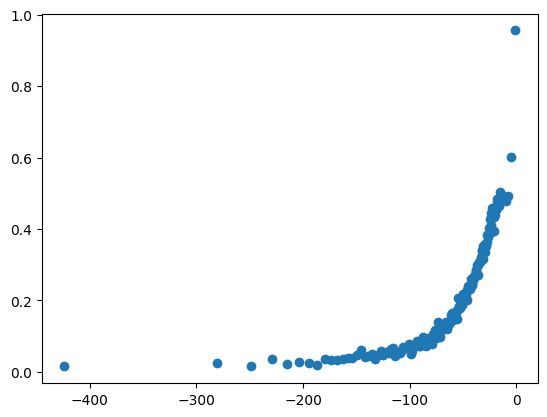

In [366]:
binned = test.get_binned(confidence_estimator="all_tokens_logprob", qa_pairs_per_bin=1000)
plt.scatter(binned["all_tokens_logprob"], binned['correct'])

In [368]:
binned['log_correct'] = np.log(binned['correct'])

In [370]:
beta = (binned['all_tokens_logprob'] * binned['log_correct']).sum() / (binned['all_tokens_logprob'] ** 2).sum()

0.021313832544389767

In [ ]:
# print(math_1000.get_examples_text(5))

In [470]:
from math_equivalence import _strip_string
from scipy import stats
r = test.results.copy()
def strip_string(x):
    if x is None:
        return None
    try:
        return _strip_string(x)
    except:
        return None
r['attempt_stripped'] = r['attempt'].apply(math_helpers.extract_boxed_expression).apply(strip_string)
r['answer_stripped'] = r['answer'].apply(math_helpers.extract_boxed_expression).apply(strip_string)

# r['attempt_stripped'] = r['attempt'].apply(gsm8k_helpers.str_to_num_parser)
# r['answer_stripped'] = r['answer'].apply(gsm8k_helpers.str_to_num_parser)
rg = r[['q_id', 'attempt_stripped', 'correct']].groupby(['q_id', 'attempt_stripped']).mean().reset_index()
rg = rg.merge(r[['q_id', 'attempt_stripped', 'all_tokens_logprob']].groupby(['q_id', 'attempt_stripped']).mean().reset_index(), on=['q_id', 'attempt_stripped'])
rg = rg.merge(r[['q_id', 'attempt_stripped']].groupby(['q_id', 'attempt_stripped']).size().reset_index(name='count'), on=['q_id', 'attempt_stripped'])

(-200.0, 0.0)

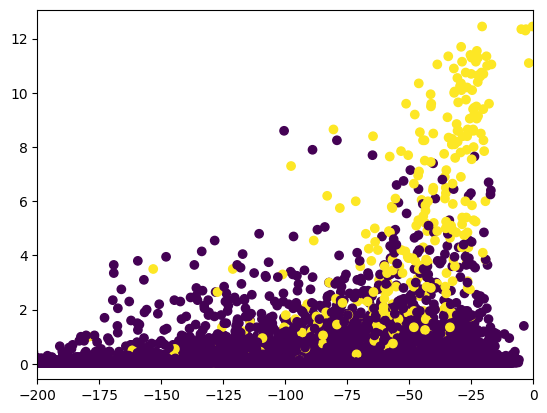

In [471]:
plt.scatter(rg['all_tokens_logprob'], rg['count'] / 20, c=rg['correct'])
plt.xlim(-200, 0)

In [478]:
rgmc = rg.assign(rng=np.random.rand(len(rg))).sort_values(['count', 'rng'], ascending=False).groupby(['q_id']).first()
rgmc.correct.sum()
# rgmc[rgmc.correct == 0].merge(r[['q_id', 'correct']].rename(columns={'correct': 'pass_20'}).groupby('q_id').max().reset_index(), on='q_id').query('pass_20 == 1').head(10)

242.0

In [ ]:
# h = rgmc[rgmc.correct == 0].merge(rg.sort_values(['all_tokens_logprob'], ascending=False).groupby(['q_id']).first(), on='q_id', suffixes=('_count', '_logprob'))

<Axes: >

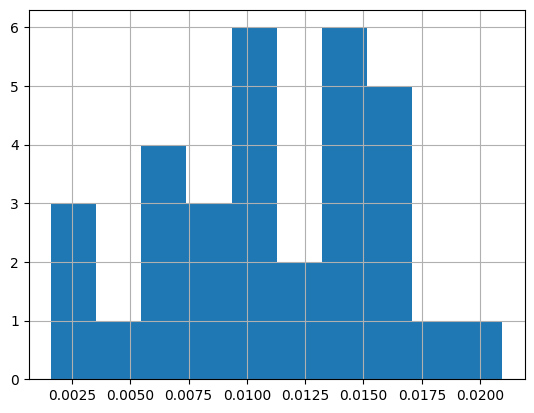

In [543]:
(
    r[(r.q_id == 3617) & (r.attempt_stripped == "8")]
    .merge(rg[["q_id", "attempt_stripped", "count"]], how='left', on=["q_id", "attempt_stripped"])
    .assign(path_weight=lambda row: np.exp(row['all_tokens_logprob'] / 50) / row['count'])
    .path_weight
    .hist()
)

In [542]:
r[r.q_id == 3617].attempt_stripped.value_counts()

attempt_stripped
10                                                                                      63
12                                                                                      59
8                                                                                       32
4                                                                                        9
6                                                                                        7
16                                                                                       7
36                                                                                       4
6\sqrt{2}                                                                                4
AB=12                                                                                    3
32                                                                                       3
6\sqrt{3}                                                                

In [544]:
rg['x'] = np.exp(rg['all_tokens_logprob'] / 50) / rg['count']
h = (rg.sort_values(['x'], ascending=False).query("count > 9").groupby(['q_id']).first()).merge(rgmc, how='left', on='q_id', suffixes=('_logprob', '_count'))
print(f"total questions: {len(h)}, correct using maj: {h.correct_count.sum()}, correct using logprob: {h.correct_logprob.sum()}")

h[h.correct_count > h.correct_logprob]

total questions: 579, correct using maj: 240.0, correct using logprob: 64.0


,attempt_stripped_logprob,correct_logprob,all_tokens_logprob_logprob,count_logprob,x,attempt_stripped_count,correct_count,all_tokens_logprob_count,count_count,rng
q_id,,,,,,,,,,
33,95,0.0,-41.352014,18,0.024297,96,1.0,-48.427572,34,0.796353
100,\frac{1}{\binom{6}{4}}=\frac{1}{15},0.0,-37.831828,11,0.042658,\frac{1}{15},1.0,-45.074663,121,0.458148
132,100000,0.0,-23.643572,22,0.028328,1000000,1.0,-19.321030,120,0.669401
168,6\frac{4}{5},0.0,-24.177695,10,0.061659,6\frac{1}{5},1.0,-32.059220,32,0.793649
179,\binom{10}{5}=252,0.0,-65.871707,10,0.026782,1024,1.0,-47.619743,76,0.642584
...,...,...,...,...,...,...,...,...,...,...
4880,\frac{5}{2},0.0,-28.067614,10,0.057044,2,1.0,-31.118546,97,0.316963
4885,\frac{36}{7},0.0,-26.523060,17,0.034608,-6,1.0,-32.554378,61,0.989654
4902,7-5=2,0.0,-66.713502,16,0.016459,2,1.0,-64.644131,168,0.369109


In [72]:
rg.sort_values(['all_tokens_logprob'], ascending=False).groupby(['q_id']).first().query("count > 0")

,attempt_stripped,correct,all_tokens_logprob,count
q_id,,,,
8,\binom{8}{3}3^32^3=1120,0.0,-17.372135,1
12,15,0.0,-18.128467,2
23,20\cdot462=9200,0.0,-19.186689,1
26,\frac{12}{10}=\frac{6}{5},0.0,-41.689544,1
29,201,0.0,-9.119968,1
...,...,...,...,...
4925,-1,0.0,-27.902723,1
4966,7782+8894=16676,0.0,-11.956311,1
4975,\frac{i}{6},0.0,-19.786974,2


In [ ]:
qs = rgmc[rgmc['count'] >= 10].reset_index()['q_id']

,q_id,attempt_stripped,correct,all_tokens_logprob,count
0,8,56,0.0,-51.450251,2
1,8,560,1.0,-25.835219,14
2,8,"\binom{8}{3,3,2}=\frac{8!}{3!3!2!}=560",0.0,-18.463191,2
3,8,"\binom{8}{3,3,2}=\frac{8!}{3!\cdot3!\cdot2!}=560",0.0,-22.987544,1
4,8,\frac{8!}{3!3!2!},0.0,-9.703553,1
...,...,...,...,...,...
7715,4981,8+(-8)=0,0.0,-27.026495,1
7727,4995,-2,0.0,-31.378442,1
7728,4995,-7,1.0,-16.712976,19
7729,4996,15,1.0,-16.095107,20


In [ ]:
r[r.q_id.isin(qs)].groupby('q_id').sample(1).reset_index().correct.sum()

365

In [ ]:
r[['q_id', 'correct']].rename(columns={'correct': 'pass_20'}).groupby('q_id').max().sum()

pass_20    789
dtype: int64

array([[<Axes: title={'center': 'count'}>]], dtype=object)

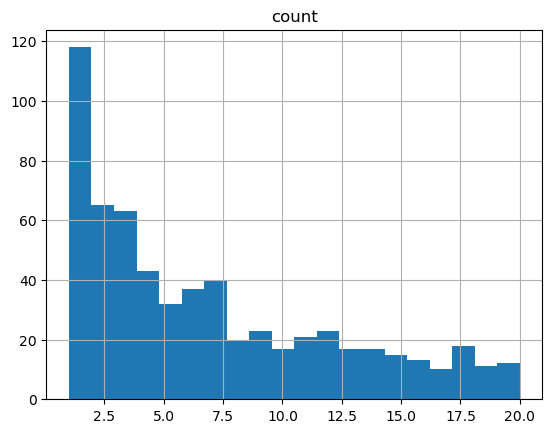

In [ ]:
rg[rg.correct == 1].hist('count', bins=20)